# DAX 40 Companies - Dataland Dimensions Analysis

Comprehensive analysis of available data dimensions across all DAX 40 companies using the Dataland API.

## Workflow:
1. Load DAX 40 company names from `dax_40.json`
2. Look up all Company IDs for each company using Dataland API
3. Extract available dimensions for all Company IDs
4. Store and persist all dimension data
5. Perform quantitative analysis:
   - Which dimensions occur most frequently?
   - Which dimensions are available for all companies?
   - Coverage statistics and visualizations

---

## 1. Setup & Imports

In [32]:
import json
import os
import requests
from pathlib import Path
from datetime import datetime
from typing import List, Dict, Any, Optional
from dataclasses import dataclass, asdict
from collections import Counter, defaultdict
import time

# Data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## 2. Configuration & API Setup

In [33]:
# Configuration
BASE_URL = "https://dataland.com"
NOTEBOOK_DIR = Path(__file__).parent if '__file__' in globals() else Path.cwd()
API_KEY_FILE = NOTEBOOK_DIR / "apikey.txt"
DAX_40_FILE = NOTEBOOK_DIR / "dax_40.json"
OUTPUT_DIR = NOTEBOOK_DIR / "dax_40_analysis_output"
OUTPUT_DIR.mkdir(exist_ok=True)

TIMEOUT = 30
YEAR_NOW = datetime.now().year
REPORTING_PERIOD_FROM = YEAR_NOW - 5
REPORTING_PERIOD_TO = YEAR_NOW

print(f"📁 Output directory: {OUTPUT_DIR.absolute()}")
print(f"📅 Analysis period: {REPORTING_PERIOD_FROM} - {REPORTING_PERIOD_TO}")

📁 Output directory: /media/andi/ssd2/dev/code/KnowledgeSolutionCorner/dax_40_analysis_output
📅 Analysis period: 2020 - 2025


In [34]:
# API Key Management
def read_api_key() -> Optional[str]:
    """Read API key from environment or apikey.txt file."""
    # Try environment variable first (DATALAND_TOKEN from mvp_pipeline)
    key = os.getenv("DATALAND_TOKEN") or os.getenv("DATALAND_API_KEY")
    if key:
        return key.strip()
    
    # Try file
    if API_KEY_FILE.exists():
        with open(API_KEY_FILE, "r") as f:
            key = f.read().strip()
            if key:
                return key
    
    return None

def get_auth_headers() -> dict:
    """Get authorization headers for API requests."""
    headers = {
        "Accept": "application/json",
        "Content-Type": "application/json"
    }
    key = read_api_key()
    if key:
        # Use token as-is (it should already include "Bearer " prefix if needed)
        # If token doesn't start with "Bearer ", add it
        if not key.startswith("Bearer "):
            headers["Authorization"] = f"Bearer {key}"
        else:
            headers["Authorization"] = key
    return headers

# Test API key
api_key = read_api_key()
if api_key:
    print(f"✅ API Key loaded (length: {len(api_key)})")
    print(f"📂 API Key file location: {API_KEY_FILE.absolute()}")
    # Show preview (first 4 and last 4 chars)
    if len(api_key) > 20:
        preview = f"{api_key[:10]}...{api_key[-4:]}"
    else:
        preview = "***"
    print(f"🔑 Token preview: {preview}")
    print(f"   Starts with 'Bearer ': {api_key.startswith('Bearer ')}")
else:
    print("⚠️  Warning: No API key found. Some requests may fail.")
    print(f"📂 Looking for API key at: {API_KEY_FILE.absolute()}")
    print(f"   File exists: {API_KEY_FILE.exists()}")
    print(f"\n💡 Tip: Make sure your apikey.txt contains either:")
    print(f"   - Just the token: sk-xxxxx")
    print(f"   - Or with Bearer prefix: Bearer sk-xxxxx")


✅ API Key loaded (length: 147)
📂 API Key file location: /media/andi/ssd2/dev/code/KnowledgeSolutionCorner/apikey.txt
🔑 Token preview: Bearer YzU...2038
   Starts with 'Bearer ': True


## 3. Data Models

In [35]:
@dataclass
class Company:
    """Company search result from Dataland API."""
    company_id: str
    company_name: str
    dax_name: str  # Original name from DAX 40 list

@dataclass
class DimensionInfo:
    """Information about a data dimension."""
    data_point_id: str
    indicator: str
    period: str
    company_id: str
    company_name: str
    dax_name: str
    raw_data: Dict[str, Any]  # Full API response for this dimension

print("✅ Data models defined")

✅ Data models defined


## 4. Load DAX 40 Companies

In [36]:
# Load DAX 40 company names
with open(DAX_40_FILE, "r", encoding="utf-8") as f:
    dax_40_companies = json.load(f)

print(f"📊 Loaded {len(dax_40_companies)} DAX 40 companies:\n")
for i, company in enumerate(dax_40_companies, 1):
    print(f"{i:2d}. {company}")

# Save to output for reference
with open(OUTPUT_DIR / "dax_40_companies.json", "w", encoding="utf-8") as f:
    json.dump(dax_40_companies, f, indent=2, ensure_ascii=False)

📊 Loaded 38 DAX 40 companies:

 1. Adidas AG
 2. Airbus SE
 3. Allianz SE
 4. BASF SE
 5. Bayer AG
 6. Beiersdorf AG
 7. Bayerische Motoren Werke AG (BMW AG)
 8. Brenntag SE
 9. Commerzbank AG
10. Continental AG
11. Daimler Truck Holding AG
12. Deutsche Bank AG
13. Deutsche Börse AG
14. Deutsche Post AG
15. Deutsche Telekom AG
16. E.ON SE
17. Fresenius Medical Care AG & Co. KGaA
18. Fresenius SE & Co. KGaA
19. Münchener Rückversicherungs-Gesellschaft AG in München
20. Heidelberg Materials AG
21. Henkel AG & Co. KGaA
22. Infineon Technologies AG
23. Mercedes-Benz Group AG
24. Merck KGaA
25. MTU Aero Engines AG
26. Porsche Automobil Holding SE
27. QIAGEN N.V.
28. Rheinmetall AG
29. RWE AG
30. SAP SE
31. Sartorius AG
32. Siemens AG
33. Siemens Energy AG
34. Siemens Healthineers AG
35. Symrise AG
36. Volkswagen AG
37. Vonovia SE
38. Zalando SE


## 5. Company ID Lookup

Search for all Company IDs for each DAX 40 company using the Dataland API.

In [37]:
def search_companies(name: str, limit: int = 100) -> List[Company]:
    """
    Search for companies by name using Dataland API.
    Returns list of Company objects with ID and name.
    """
    if not name:
        return []
    
    url = f"{BASE_URL}/api/companies/names"
    params = {
        "searchString": name,
        "resultLimit": limit
    }
    
    try:
        response = requests.get(
            url,
            params=params,
            headers=get_auth_headers(),
            timeout=TIMEOUT
        )
        response.raise_for_status()
        data = response.json()
        
        results = []
        for item in data:
            if isinstance(item, dict):
                results.append(Company(
                    company_id=item.get("companyId", ""),
                    company_name=item.get("companyName", ""),
                    dax_name=name
                ))
        return results
    
    except requests.RequestException as e:
        print(f"❌ Error searching for '{name}': {e}")
        return []

print("✅ Company search function defined")

✅ Company search function defined


In [38]:
# Look up all Company IDs for DAX 40 companies
print("🔍 Looking up Company IDs for all DAX 40 companies...\n")
print("="*80)

all_companies = []
company_lookup = {}  # dax_name -> list of Company objects
lookup_stats = []

for i, dax_name in enumerate(dax_40_companies, 1):
    print(f"\n[{i}/{len(dax_40_companies)}] Searching: {dax_name}")
    
    companies = search_companies(dax_name, limit=100)
    company_lookup[dax_name] = companies
    all_companies.extend(companies)
    
    if companies:
        print(f"   ✅ Found {len(companies)} Company ID(s):")
        for j, company in enumerate(companies[:5], 1):
            print(f"      {j}. {company.company_name} (ID: {company.company_id})")
        if len(companies) > 5:
            print(f"      ... and {len(companies) - 5} more")
    else:
        print(f"   ⚠️  No Company IDs found")
    
    lookup_stats.append({
        "dax_name": dax_name,
        "num_ids": len(companies),
        "company_ids": [c.company_id for c in companies]
    })
    
    # Rate limiting
    time.sleep(0.5)

print("\n" + "="*80)
print(f"\n✅ Company ID Lookup Complete!")
print(f"   Total DAX 40 companies: {len(dax_40_companies)}")
print(f"   Total Company IDs found: {len(all_companies)}")
print(f"   Average IDs per company: {len(all_companies) / len(dax_40_companies):.2f}")

# Save lookup results
with open(OUTPUT_DIR / "company_lookup_results.json", "w", encoding="utf-8") as f:
    json.dump(lookup_stats, f, indent=2, ensure_ascii=False)

print(f"\n💾 Saved lookup results to: {OUTPUT_DIR / 'company_lookup_results.json'}")

🔍 Looking up Company IDs for all DAX 40 companies...


[1/38] Searching: Adidas AG
   ✅ Found 1 Company ID(s):
      1. adidas AG (ID: b74fe176-8886-4127-aa88-a45a32c386ac)
   ✅ Found 1 Company ID(s):
      1. adidas AG (ID: b74fe176-8886-4127-aa88-a45a32c386ac)

[2/38] Searching: Airbus SE
   ✅ Found 2 Company ID(s):
      1. AIRBUS SE (ID: e716b566-c308-45c6-88be-b4d317a4fe93)
      2. AIRBUS SECURE LAND COMMUNICATIONS GMBH (ID: 29243f6f-50ab-4d78-bc3a-c810e913599f)

[2/38] Searching: Airbus SE
   ✅ Found 2 Company ID(s):
      1. AIRBUS SE (ID: e716b566-c308-45c6-88be-b4d317a4fe93)
      2. AIRBUS SECURE LAND COMMUNICATIONS GMBH (ID: 29243f6f-50ab-4d78-bc3a-c810e913599f)

[3/38] Searching: Allianz SE

[3/38] Searching: Allianz SE
   ✅ Found 29 Company ID(s):
      1. Allianz SE (ID: 4fdfb860-855e-4a08-81a0-129bd172dc1e)
      2. Allianz SE Ashmore Emerging Markets Corporates Fund (ID: 8ab211df-38e7-4263-9aa4-967f81c867a7)
      3. ALLIANZ SECTEUR EURO IMMOBILIER (ID: 5243c4a8-bd2a-4

## 6. Company ID Statistics

In [39]:
# Analyze Company ID distribution
df_lookup = pd.DataFrame(lookup_stats)

print("\n📊 Company ID Distribution Statistics:\n")
print(df_lookup['num_ids'].describe())

print("\n\n📋 Companies with multiple IDs:")
multiple_ids = df_lookup[df_lookup['num_ids'] > 1].sort_values('num_ids', ascending=False)
if not multiple_ids.empty:
    for _, row in multiple_ids.head(10).iterrows():
        print(f"   • {row['dax_name']}: {row['num_ids']} IDs")
else:
    print("   (No companies with multiple IDs)")

print("\n\n⚠️  Companies with NO IDs found:")
no_ids = df_lookup[df_lookup['num_ids'] == 0]
if not no_ids.empty:
    for _, row in no_ids.iterrows():
        print(f"   • {row['dax_name']}")
else:
    print("   ✅ All companies have at least one ID!")


📊 Company ID Distribution Statistics:

count    38.000000
mean      2.421053
std       4.885896
min       0.000000
25%       1.000000
50%       1.000000
75%       2.000000
max      29.000000
Name: num_ids, dtype: float64


📋 Companies with multiple IDs:
   • Allianz SE: 29 IDs
   • SAP SE: 12 IDs
   • Continental AG: 5 IDs
   • Deutsche Bank AG: 5 IDs
   • Bayer AG: 4 IDs
   • BASF SE: 3 IDs
   • Airbus SE: 2 IDs
   • Commerzbank AG: 2 IDs
   • E.ON SE: 2 IDs
   • Heidelberg Materials AG: 2 IDs


⚠️  Companies with NO IDs found:
   • Bayerische Motoren Werke AG (BMW AG)
   • Münchener Rückversicherungs-Gesellschaft AG in München
   • RWE AG
   • Volkswagen AG


In [40]:
# Visualize Company ID distribution
fig = px.histogram(
    df_lookup,
    x='num_ids',
    title='Distribution of Company IDs per DAX 40 Company',
    labels={'num_ids': 'Number of Company IDs', 'count': 'Number of Companies'},
    nbins=20
)
fig.update_layout(showlegend=False)
fig.show()

# Save plot
fig.write_html(OUTPUT_DIR / "company_id_distribution.html")

## 7. Extract Dimensions for All Company IDs

Using the Dataland API to get available data dimensions for each Company ID.

In [41]:
def get_available_dimensions(company_id: str) -> Optional[List[Dict[str, Any]]]:
    """
    Get available data dimensions for a company from Dataland API.
    Based on mvp_pipeline.ipynb cell 14.
    
    Important:
    - Endpoint path must match mvp_pipeline: /api/metadata/available-data-dimensions
    - Uses GET request with params (requests handles array serialization)
    - Must include companyIds as array and reporting period filters
    """
    # Construct full URL (mvp_pipeline uses base_url/api + endpoint)
    url = f"{BASE_URL}/api/metadata/available-data-dimensions"
    
    # Parameters as expected by Dataland API
    # Note: companyIds is PLURAL and expects an array
    params = {
        "companyIds": company_id,  # requests will handle this correctly
        "reportingPeriodFrom": REPORTING_PERIOD_FROM,
        "reportingPeriodTo": REPORTING_PERIOD_TO
    }
    
    try:
        response = requests.get(
            url,
            params=params,
            headers=get_auth_headers(),
            timeout=TIMEOUT
        )
        
        if response.status_code != 200:
            print(f"   ⚠️  HTTP {response.status_code} for company {company_id}")
            if response.status_code == 400:
                try:
                    error_detail = response.json()
                    print(f"   Error: {error_detail}")
                except:
                    print(f"   Error: {response.text[:200]}")
            elif response.status_code == 401:
                print(f"   ❌ Authentication failed - check your API token")
            return None
        
        data = response.json()
        
        # Extract dimensions from response (flexible parsing)
        dims = None
        if isinstance(data, dict):
            for key in ("availableDataPoints", "dimensions", "dataPoints", "data", "results", "items"):
                if key in data and isinstance(data[key], list):
                    dims = data[key]
                    break
        if dims is None and isinstance(data, list):
            dims = data
        
        return dims if dims else []
    
    except requests.RequestException as e:
        print(f"   ❌ Error fetching dimensions for {company_id}: {e}")
        return None

print("✅ Dimension extraction function defined")

✅ Dimension extraction function defined


In [42]:
# Extract dimensions for all Company IDs
print("🔍 Extracting dimensions for all Company IDs...\n")
print("="*80)

all_dimensions = []
dimension_stats = []
failed_companies = []

for i, company in enumerate(all_companies, 1):
    print(f"\n[{i}/{len(all_companies)}] {company.company_name} (ID: {company.company_id})")
    print(f"   DAX Name: {company.dax_name}")
    
    dimensions = get_available_dimensions(company.company_id)
    
    if dimensions is None:
        print(f"   ❌ Failed to retrieve dimensions")
        failed_companies.append(company)
        dimension_stats.append({
            "company_id": company.company_id,
            "company_name": company.company_name,
            "dax_name": company.dax_name,
            "num_dimensions": 0,
            "success": False
        })
    elif len(dimensions) == 0:
        print(f"   ℹ️  No dimensions found (empty)")
        dimension_stats.append({
            "company_id": company.company_id,
            "company_name": company.company_name,
            "dax_name": company.dax_name,
            "num_dimensions": 0,
            "success": True
        })
    else:
        print(f"   ✅ Found {len(dimensions)} dimensions")
        
        # Parse and store dimensions
        # Correct parsing: use "dataType" as indicator and "reportingPeriod" as period
        for dim in dimensions:
            dim_info = DimensionInfo(
                data_point_id=dim.get("dataPointId") or dim.get("id") or f"{company.company_id}_{dim.get('dataType')}_{dim.get('reportingPeriod')}",
                indicator=dim.get("dataType", "unknown"),  # ← FIXED: use dataType as indicator
                period=str(dim.get("reportingPeriod", "unknown")),  # ← FIXED: use reportingPeriod
                company_id=company.company_id,
                company_name=company.company_name,
                dax_name=company.dax_name,
                raw_data=dim
            )
            all_dimensions.append(dim_info)
        
        dimension_stats.append({
            "company_id": company.company_id,
            "company_name": company.company_name,
            "dax_name": company.dax_name,
            "num_dimensions": len(dimensions),
            "success": True
        })
    
    # Rate limiting
    time.sleep(0.5)

print("\n" + "="*80)
print(f"\n✅ Dimension Extraction Complete!")
print(f"   Total Company IDs processed: {len(all_companies)}")
print(f"   Total dimensions found: {len(all_dimensions)}")
print(f"   Failed requests: {len(failed_companies)}")

if len(all_companies) > 0:
    print(f"   Average dimensions per company: {len(all_dimensions) / len(all_companies):.2f}")


🔍 Extracting dimensions for all Company IDs...


[1/92] adidas AG (ID: b74fe176-8886-4127-aa88-a45a32c386ac)
   DAX Name: Adidas AG
   ✅ Found 253 dimensions
   ✅ Found 253 dimensions

[2/92] AIRBUS SE (ID: e716b566-c308-45c6-88be-b4d317a4fe93)
   DAX Name: Airbus SE
   ✅ Found 425 dimensions

[2/92] AIRBUS SE (ID: e716b566-c308-45c6-88be-b4d317a4fe93)
   DAX Name: Airbus SE
   ✅ Found 425 dimensions

[3/92] AIRBUS SECURE LAND COMMUNICATIONS GMBH (ID: 29243f6f-50ab-4d78-bc3a-c810e913599f)
   DAX Name: Airbus SE
   ℹ️  No dimensions found (empty)

[3/92] AIRBUS SECURE LAND COMMUNICATIONS GMBH (ID: 29243f6f-50ab-4d78-bc3a-c810e913599f)
   DAX Name: Airbus SE
   ℹ️  No dimensions found (empty)

[4/92] Allianz SE (ID: 4fdfb860-855e-4a08-81a0-129bd172dc1e)
   DAX Name: Allianz SE
   ✅ Found 347 dimensions

[4/92] Allianz SE (ID: 4fdfb860-855e-4a08-81a0-129bd172dc1e)
   DAX Name: Allianz SE
   ✅ Found 347 dimensions

[5/92] Allianz SE Ashmore Emerging Markets Corporates Fund (ID: 8ab211df-38

## 8. Save Dimension Data

In [43]:
# Save dimension statistics
df_dim_stats = pd.DataFrame(dimension_stats)
df_dim_stats.to_csv(OUTPUT_DIR / "dimension_statistics.csv", index=False)
df_dim_stats.to_json(OUTPUT_DIR / "dimension_statistics.json", orient="records", indent=2)

print(f"💾 Saved dimension statistics to:")
print(f"   - {OUTPUT_DIR / 'dimension_statistics.csv'}")
print(f"   - {OUTPUT_DIR / 'dimension_statistics.json'}")

# Save all dimensions (structured)
all_dimensions_dict = [asdict(dim) for dim in all_dimensions]
with open(OUTPUT_DIR / "all_dimensions_full.json", "w", encoding="utf-8") as f:
    json.dump(all_dimensions_dict, f, indent=2, ensure_ascii=False)

print(f"\n💾 Saved all dimensions to:")
print(f"   - {OUTPUT_DIR / 'all_dimensions_full.json'}")

# Create DataFrame for analysis
df_dimensions = pd.DataFrame([
    {
        "data_point_id": dim.data_point_id,
        "indicator": dim.indicator,
        "period": dim.period,
        "company_id": dim.company_id,
        "company_name": dim.company_name,
        "dax_name": dim.dax_name
    }
    for dim in all_dimensions
])

df_dimensions.to_csv(OUTPUT_DIR / "all_dimensions.csv", index=False)
print(f"\n💾 Saved dimensions DataFrame to:")
print(f"   - {OUTPUT_DIR / 'all_dimensions.csv'}")

print(f"\n📊 Dimensions DataFrame shape: {df_dimensions.shape}")

💾 Saved dimension statistics to:
   - /media/andi/ssd2/dev/code/KnowledgeSolutionCorner/dax_40_analysis_output/dimension_statistics.csv
   - /media/andi/ssd2/dev/code/KnowledgeSolutionCorner/dax_40_analysis_output/dimension_statistics.json

💾 Saved all dimensions to:
   - /media/andi/ssd2/dev/code/KnowledgeSolutionCorner/dax_40_analysis_output/all_dimensions_full.json

💾 Saved dimensions DataFrame to:
   - /media/andi/ssd2/dev/code/KnowledgeSolutionCorner/dax_40_analysis_output/all_dimensions.csv

📊 Dimensions DataFrame shape: (12419, 6)

💾 Saved dimensions DataFrame to:
   - /media/andi/ssd2/dev/code/KnowledgeSolutionCorner/dax_40_analysis_output/all_dimensions.csv

📊 Dimensions DataFrame shape: (12419, 6)


## 9. Quantitative Analysis: Overview

In [44]:
# Basic statistics
print("="*80)
print("📊 QUANTITATIVE ANALYSIS - OVERVIEW")
print("="*80)

print(f"\n📈 Overall Statistics:")
print(f"   Total DAX 40 Companies: {len(dax_40_companies)}")
print(f"   Total Company IDs: {len(all_companies)}")
print(f"   Total Dimensions Found: {len(all_dimensions)}")
print(f"   Unique Indicators: {df_dimensions['indicator'].nunique()}")
print(f"   Unique Periods: {df_dimensions['period'].nunique()}")

print(f"\n📊 Dimensions per Company Statistics:")
if not df_dim_stats.empty:
    print(df_dim_stats['num_dimensions'].describe())

print(f"\n✅ Companies with Dimensions: {len(df_dim_stats[df_dim_stats['num_dimensions'] > 0])}")
print(f"⚠️  Companies without Dimensions: {len(df_dim_stats[df_dim_stats['num_dimensions'] == 0])}")

📊 QUANTITATIVE ANALYSIS - OVERVIEW

📈 Overall Statistics:
   Total DAX 40 Companies: 38
   Total Company IDs: 92
   Total Dimensions Found: 12419
   Unique Indicators: 338
   Unique Periods: 3

📊 Dimensions per Company Statistics:
count     92.000000
mean     134.989130
std      186.437362
min        0.000000
25%        0.000000
50%        0.000000
75%      384.250000
max      452.000000
Name: num_dimensions, dtype: float64

✅ Companies with Dimensions: 33
⚠️  Companies without Dimensions: 59


## 10. Indicator Frequency Analysis

In [45]:
# Count indicator occurrences
indicator_counts = df_dimensions['indicator'].value_counts()

print("="*80)
print("📊 INDICATOR FREQUENCY ANALYSIS")
print("="*80)

print(f"\n🔝 Top 20 Most Common Indicators:\n")
for i, (indicator, count) in enumerate(indicator_counts.head(20).items(), 1):
    percentage = (count / len(all_dimensions)) * 100
    print(f"{i:2d}. {indicator:60s} → {count:4d} occurrences ({percentage:5.2f}%)")

# Save full indicator frequency
indicator_freq_df = indicator_counts.reset_index()
indicator_freq_df.columns = ['indicator', 'count']
indicator_freq_df['percentage'] = (indicator_freq_df['count'] / len(all_dimensions)) * 100
indicator_freq_df.to_csv(OUTPUT_DIR / "indicator_frequency.csv", index=False)

print(f"\n💾 Saved full indicator frequency to: {OUTPUT_DIR / 'indicator_frequency.csv'}")

📊 INDICATOR FREQUENCY ANALYSIS

🔝 Top 20 Most Common Indicators:

 1. plainEnumFiscalYearDeviation                                 →   66 occurrences ( 0.53%)
 2. extendedEnumYesNoControversialWeaponsExposure                →   66 occurrences ( 0.53%)
 3. plainDateSfdrDataDate                                        →   66 occurrences ( 0.53%)
 4. sfdr                                                         →   66 occurrences ( 0.53%)
 5. plainDateFiscalYearEnd                                       →   66 occurrences ( 0.53%)
 6. pcaf                                                         →   66 occurrences ( 0.53%)
 7. extendedEnumYesNoHumanRightsDueDiligence                     →   65 occurrences ( 0.52%)
 8. extendedEnumYesNoIloCoreLabourStandards                      →   65 occurrences ( 0.52%)
 9. extendedEnumYesNoUnGlobalCompactPrinciplesCompliancePolicy   →   65 occurrences ( 0.52%)
10. extendedEnumYesNoCorruptionLegalProceedings                  →   64 occurrences ( 0.52%)
11. 

In [46]:
# Visualize top indicators
top_n = 25
fig = px.bar(
    indicator_freq_df.head(top_n),
    x='count',
    y='indicator',
    orientation='h',
    title=f'Top {top_n} Most Frequent Indicators Across DAX 40',
    labels={'count': 'Number of Occurrences', 'indicator': 'Indicator'},
    text='count'
)
fig.update_layout(height=800, yaxis={'categoryorder':'total ascending'})
fig.update_traces(textposition='outside')
fig.show()

fig.write_html(OUTPUT_DIR / "top_indicators.html")

## 11. Coverage Analysis: Which Indicators Are Available Everywhere?

In [47]:
# Analyze indicator coverage across companies
print("="*80)
print("📊 COVERAGE ANALYSIS")
print("="*80)

# Count unique companies per indicator
indicator_company_coverage = df_dimensions.groupby('indicator')['company_id'].nunique().reset_index()
indicator_company_coverage.columns = ['indicator', 'num_companies']
indicator_company_coverage['coverage_percentage'] = (
    indicator_company_coverage['num_companies'] / len(all_companies)
) * 100
indicator_company_coverage = indicator_company_coverage.sort_values('num_companies', ascending=False)

# Universal indicators (available for all companies)
universal_indicators = indicator_company_coverage[
    indicator_company_coverage['num_companies'] == len(all_companies)
]

print(f"\n✨ Universal Indicators (available for ALL {len(all_companies)} Company IDs):\n")
if not universal_indicators.empty:
    for i, row in universal_indicators.iterrows():
        print(f"   • {row['indicator']}")
else:
    print("   (No indicators available for all companies)")

# High coverage indicators (>= 80%)
high_coverage = indicator_company_coverage[
    indicator_company_coverage['coverage_percentage'] >= 80
]

print(f"\n📈 High Coverage Indicators (>= 80% of companies):\n")
if not high_coverage.empty:
    for i, row in high_coverage.head(20).iterrows():
        print(f"   • {row['indicator']:60s} → {row['num_companies']:3d} companies ({row['coverage_percentage']:5.1f}%)")
else:
    print("   (No indicators with >= 80% coverage)")

# Save coverage analysis
indicator_company_coverage.to_csv(OUTPUT_DIR / "indicator_coverage.csv", index=False)
print(f"\n💾 Saved coverage analysis to: {OUTPUT_DIR / 'indicator_coverage.csv'}")

📊 COVERAGE ANALYSIS

✨ Universal Indicators (available for ALL 92 Company IDs):

   (No indicators available for all companies)

📈 High Coverage Indicators (>= 80% of companies):

   (No indicators with >= 80% coverage)

💾 Saved coverage analysis to: /media/andi/ssd2/dev/code/KnowledgeSolutionCorner/dax_40_analysis_output/indicator_coverage.csv


In [48]:
# Visualize coverage distribution
fig = px.histogram(
    indicator_company_coverage,
    x='coverage_percentage',
    nbins=20,
    title='Distribution of Indicator Coverage Across Companies',
    labels={'coverage_percentage': 'Coverage Percentage (%)', 'count': 'Number of Indicators'}
)
fig.show()

fig.write_html(OUTPUT_DIR / "indicator_coverage_distribution.html")

In [49]:
# Top indicators by coverage
top_coverage_n = 30
fig = px.bar(
    indicator_company_coverage.head(top_coverage_n),
    x='num_companies',
    y='indicator',
    orientation='h',
    title=f'Top {top_coverage_n} Indicators by Company Coverage',
    labels={'num_companies': 'Number of Companies', 'indicator': 'Indicator'},
    text='num_companies',
    hover_data=['coverage_percentage']
)
fig.update_layout(height=900, yaxis={'categoryorder':'total ascending'})
fig.update_traces(textposition='outside')
fig.show()

fig.write_html(OUTPUT_DIR / "top_indicators_by_coverage.html")

## 12. Company-Level Analysis

In [50]:
# Companies with most dimensions
print("="*80)
print("📊 COMPANY-LEVEL ANALYSIS")
print("="*80)

df_dim_stats_sorted = df_dim_stats.sort_values('num_dimensions', ascending=False)

print(f"\n🏆 Top 20 Companies by Number of Dimensions:\n")
for i, row in df_dim_stats_sorted.head(20).iterrows():
    print(f"{i+1:2d}. {row['dax_name']:50s} → {row['num_dimensions']:4d} dimensions")
    print(f"    Company: {row['company_name']} (ID: {row['company_id']})")

print(f"\n⚠️  Companies with NO Dimensions:\n")
no_dims = df_dim_stats_sorted[df_dim_stats_sorted['num_dimensions'] == 0]
if not no_dims.empty:
    for i, row in no_dims.iterrows():
        print(f"   • {row['dax_name']} - {row['company_name']} (ID: {row['company_id']})")
else:
    print("   ✅ All companies have at least one dimension!")

📊 COMPANY-LEVEL ANALYSIS

🏆 Top 20 Companies by Number of Dimensions:

49. Daimler Truck Holding AG                           →  452 dimensions
    Company: Daimler Truck Holding AG (ID: 9081abb0-094f-41fa-b6ee-b7a47e3fe390)
58. E.ON SE                                            →  447 dimensions
    Company: E.ON SE (ID: 17ddbb60-1348-47e1-9c56-6dc6c5fdf4c9)
55. Deutsche Börse AG                                  →  429 dimensions
    Company: Deutsche Börse Aktiengesellschaft (ID: 4db3fb50-0540-432f-ad0f-f41848608a8d)
33. BASF SE                                            →  428 dimensions
    Company: BASF SE (ID: 10075779-5ce0-4e38-961f-4b350d3be287)
 2. Airbus SE                                          →  425 dimensions
    Company: AIRBUS SE (ID: e716b566-c308-45c6-88be-b4d317a4fe93)
87. Siemens Energy AG                                  →  423 dimensions
    Company: Siemens Energy AG (ID: 39260625-315b-4158-97aa-64b69eb331db)
85. Siemens AG                                      

In [51]:
# Visualize dimensions per company
fig = px.histogram(
    df_dim_stats,
    x='num_dimensions',
    nbins=30,
    title='Distribution of Dimensions per Company ID',
    labels={'num_dimensions': 'Number of Dimensions', 'count': 'Number of Companies'}
)
fig.show()

fig.write_html(OUTPUT_DIR / "dimensions_per_company_distribution.html")

In [52]:
# Top companies bar chart
top_companies_n = 30
fig = px.bar(
    df_dim_stats_sorted.head(top_companies_n),
    x='num_dimensions',
    y='company_name',
    orientation='h',
    title=f'Top {top_companies_n} Companies by Number of Dimensions',
    labels={'num_dimensions': 'Number of Dimensions', 'company_name': 'Company'},
    text='num_dimensions',
    hover_data=['dax_name', 'company_id']
)
fig.update_layout(height=900, yaxis={'categoryorder':'total ascending'})
fig.update_traces(textposition='outside')
fig.show()

fig.write_html(OUTPUT_DIR / "top_companies_by_dimensions.html")

## 13. Period Analysis

In [53]:
# Analyze reporting periods
print("="*80)
print("📊 REPORTING PERIOD ANALYSIS")
print("="*80)

period_counts = df_dimensions['period'].value_counts()

print(f"\n📅 Dimensions by Reporting Period:\n")
for period, count in period_counts.head(20).items():
    percentage = (count / len(all_dimensions)) * 100
    print(f"   {period:15s} → {count:5d} dimensions ({percentage:5.2f}%)")

# Save period analysis
period_freq_df = period_counts.reset_index()
period_freq_df.columns = ['period', 'count']
period_freq_df['percentage'] = (period_freq_df['count'] / len(all_dimensions)) * 100
period_freq_df.to_csv(OUTPUT_DIR / "period_frequency.csv", index=False)

print(f"\n💾 Saved period frequency to: {OUTPUT_DIR / 'period_frequency.csv'}")

📊 REPORTING PERIOD ANALYSIS

📅 Dimensions by Reporting Period:

   2023            →  6140 dimensions (49.44%)
   2024            →  6134 dimensions (49.39%)
   2022            →   145 dimensions ( 1.17%)

💾 Saved period frequency to: /media/andi/ssd2/dev/code/KnowledgeSolutionCorner/dax_40_analysis_output/period_frequency.csv


In [54]:
# Visualize period distribution
fig = px.bar(
    period_freq_df.head(20),
    x='period',
    y='count',
    title='Top 20 Reporting Periods by Dimension Count',
    labels={'period': 'Reporting Period', 'count': 'Number of Dimensions'},
    text='count'
)
fig.update_traces(textposition='outside')
fig.show()

fig.write_html(OUTPUT_DIR / "period_distribution.html")

## 14. Cross-Analysis: Indicators vs Companies Heatmap

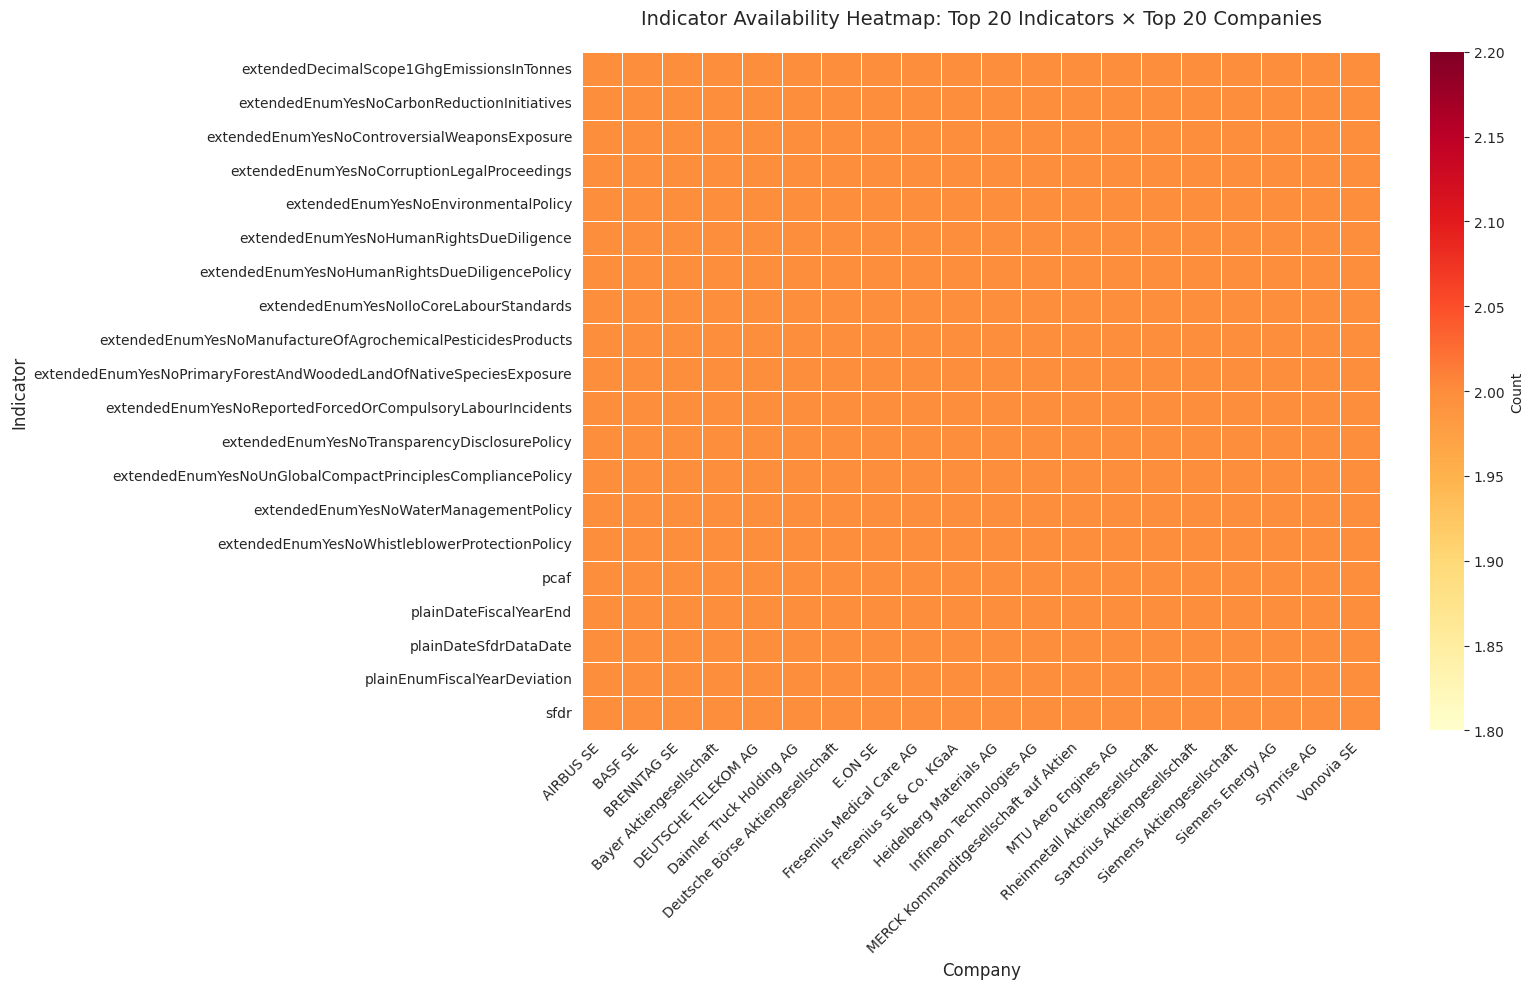

💾 Saved heatmap to: /media/andi/ssd2/dev/code/KnowledgeSolutionCorner/dax_40_analysis_output/indicator_company_heatmap.png


In [55]:
# Create indicator-company matrix
# Use top indicators and companies for visualization
top_indicators_list = indicator_counts.head(20).index.tolist()
top_companies_list = df_dim_stats_sorted.head(20)['company_id'].tolist()

# Filter data
df_filtered = df_dimensions[
    (df_dimensions['indicator'].isin(top_indicators_list)) &
    (df_dimensions['company_id'].isin(top_companies_list))
]

# Create pivot table
pivot_data = df_filtered.groupby(['indicator', 'company_name']).size().unstack(fill_value=0)

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(
    pivot_data,
    cmap='YlOrRd',
    annot=False,
    cbar_kws={'label': 'Count'},
    linewidths=0.5
)
plt.title('Indicator Availability Heatmap: Top 20 Indicators × Top 20 Companies', fontsize=14, pad=20)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Indicator', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "indicator_company_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Saved heatmap to: {OUTPUT_DIR / 'indicator_company_heatmap.png'}")

## 15. Summary Report

In [56]:
# Generate summary report
summary_report = {
    "analysis_date": datetime.now().isoformat(),
    "data_collection": {
        "dax_40_companies": len(dax_40_companies),
        "total_company_ids": len(all_companies),
        "avg_ids_per_company": len(all_companies) / len(dax_40_companies) if len(dax_40_companies) > 0 else 0,
        "failed_lookups": len(failed_companies)
    },
    "dimensions": {
        "total_dimensions": len(all_dimensions),
        "unique_indicators": df_dimensions['indicator'].nunique() if not df_dimensions.empty else 0,
        "unique_periods": df_dimensions['period'].nunique() if not df_dimensions.empty else 0,
        "avg_dimensions_per_company": len(all_dimensions) / len(all_companies) if len(all_companies) > 0 else 0
    },
    "coverage": {
        "companies_with_dimensions": len(df_dim_stats[df_dim_stats['num_dimensions'] > 0]),
        "companies_without_dimensions": len(df_dim_stats[df_dim_stats['num_dimensions'] == 0]),
        "universal_indicators": len(universal_indicators),
        "high_coverage_indicators_80pct": len(high_coverage)
    },
    "top_indicators": indicator_counts.head(10).to_dict(),
    "top_companies_by_dimensions": df_dim_stats_sorted[['company_name', 'num_dimensions']].head(10).to_dict('records')
}

# Save summary report
with open(OUTPUT_DIR / "summary_report.json", "w", encoding="utf-8") as f:
    json.dump(summary_report, f, indent=2, ensure_ascii=False)

print("="*80)
print("📊 FINAL SUMMARY REPORT")
print("="*80)
print(json.dumps(summary_report, indent=2, ensure_ascii=False))
print(f"\n💾 Saved summary report to: {OUTPUT_DIR / 'summary_report.json'}")

📊 FINAL SUMMARY REPORT
{
  "analysis_date": "2025-11-12T22:03:53.701605",
  "data_collection": {
    "dax_40_companies": 38,
    "total_company_ids": 92,
    "avg_ids_per_company": 2.4210526315789473,
    "failed_lookups": 0
  },
  "dimensions": {
    "total_dimensions": 12419,
    "unique_indicators": 338,
    "unique_periods": 3,
    "avg_dimensions_per_company": 134.9891304347826
  },
  "coverage": {
    "companies_with_dimensions": 33,
    "companies_without_dimensions": 59,
    "universal_indicators": 0,
    "high_coverage_indicators_80pct": 0
  },
  "top_indicators": {
    "plainEnumFiscalYearDeviation": 66,
    "extendedEnumYesNoControversialWeaponsExposure": 66,
    "plainDateSfdrDataDate": 66,
    "sfdr": 66,
    "plainDateFiscalYearEnd": 66,
    "pcaf": 66,
    "extendedEnumYesNoHumanRightsDueDiligence": 65,
    "extendedEnumYesNoIloCoreLabourStandards": 65,
    "extendedEnumYesNoUnGlobalCompactPrinciplesCompliancePolicy": 65,
    "extendedEnumYesNoCorruptionLegalProceedings"

## 16. Output Files Summary

In [57]:
# List all generated files
print("="*80)
print("📁 GENERATED OUTPUT FILES")
print("="*80)
print(f"\nAll files saved in: {OUTPUT_DIR.absolute()}\n")

output_files = sorted(OUTPUT_DIR.glob("*"))
for i, file_path in enumerate(output_files, 1):
    size_kb = file_path.stat().st_size / 1024
    print(f"{i:2d}. {file_path.name:50s} ({size_kb:8.2f} KB)")

print(f"\n✅ Analysis complete! Total files generated: {len(output_files)}")

📁 GENERATED OUTPUT FILES

All files saved in: /media/andi/ssd2/dev/code/KnowledgeSolutionCorner/dax_40_analysis_output

 1. all_dimensions.csv                                 ( 2985.35 KB)
 2. all_dimensions_full.json                           ( 7005.65 KB)
 3. company_id_distribution.html                       ( 3522.12 KB)
 4. company_lookup_results.json                        (    7.45 KB)
 5. dax_40_companies.json                              (    0.84 KB)
 6. dimension_statistics.csv                           (    7.91 KB)
 7. dimension_statistics.json                          (   17.33 KB)
 8. dimensions_per_company_distribution.html           ( 3522.26 KB)
 9. indicator_company_heatmap.png                      (  910.01 KB)
10. indicator_coverage.csv                             (   37.31 KB)
11. indicator_coverage_distribution.html               ( 3528.25 KB)
12. indicator_frequency.csv                            (   37.48 KB)
13. period_distribution.html                        